In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

1. $W(\Delta t) \sim \mathcal{N}(0, \Delta t)$

In [2]:
def generate_wiener(end_t: float, number_of_points: int):
    t_grid, dt = np.linspace(0, end_t, number_of_points, endpoint=False, retstep=True)
    normal_cumsum = sps.norm(loc=0, scale=dt**0.5) \
                       .rvs(size=number_of_points - 1) \
                       .cumsum()
    normal_cumsum = np.insert(normal_cumsum, 0, 0)
    return t_grid, normal_cumsum

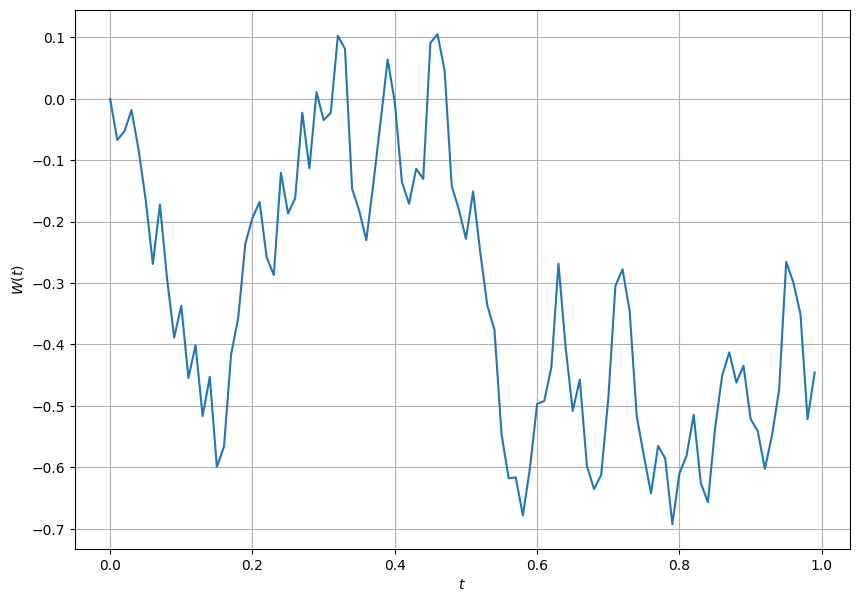

In [3]:
N = 100
T = 1

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(*generate_wiener(T, N))
ax.set_xlabel('$t$')
ax.set_ylabel('$W(t)$')
ax.grid();

2. $S_n = X_1 + \ldots + X_n$

   $$ \frac{S_n}{\sqrt{n}} \sim \mathcal{N}(0, ?) $$

In [4]:
def wiener_brownian_limit(end_t: float, number_of_points: int):
    time_grid = np.linspace(0, end_t, number_of_points, endpoint=True)
    bernoulli_sample = 2 * sps.bernoulli.rvs(p=0.5, size=(number_of_points - 1)) - 1
    binomial_sample = bernoulli_sample.cumsum()
    wiener = binomial_sample / number_of_points**0.5
    wiener = np.insert(wiener, 0, 0)
    return time_grid, wiener

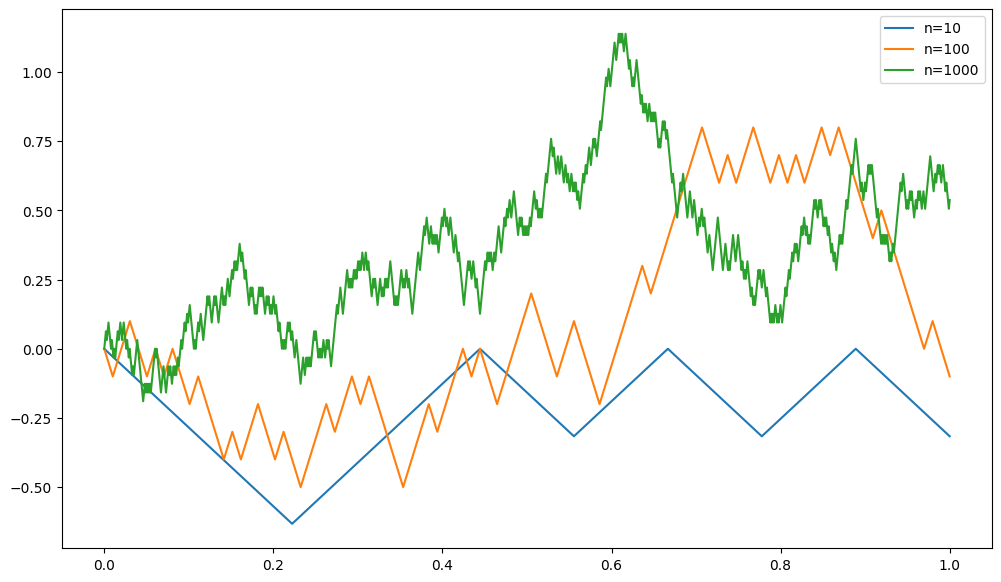

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))

for n in (10, 100, 1000):
    ax.plot(*wiener_brownian_limit(T, n), label=f'{n=}')
    
ax.legend()

3. $$ W(t) = \sum_{i=0}^\infty Z_i \varphi(t) $$

In [6]:
def karhunen_loeve(end_t: float, number_of_points: int, number_of_terms: int):
    t_grid = np.linspace(0, end_t, number_of_points)
    normal_sample = sps.norm.rvs(size=number_of_terms)
    
    def W_t(t: float):
        term_idxs = np.arange(number_of_terms) * 2 + 1
        phi_s = 2 * (2 * end_t)**0.5 / (np.pi * term_idxs) * np.sin(term_idxs * np.pi * t / 2 / end_t)
        return (normal_sample * phi_s).sum()
    
    wiener = np.empty_like(t_grid)
    for i, t in enumerate(t_grid):
        wiener[i] = W_t(t)
    return t_grid, wiener

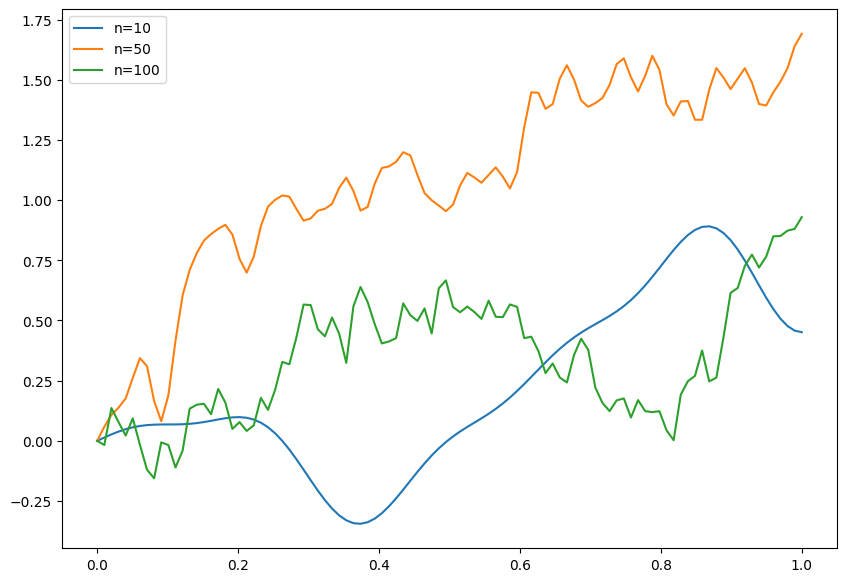

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

for n in (10, 50, 100):
    ax.plot(*karhunen_loeve(T, N, n), label=f'{n=}')
ax.legend()

4. Geometric Brownian Motion

In [8]:
def generate_geometric_bm(s_0: float, rate: float, volatility: float, end_t: float, number_of_points: int):
    r, sig = rate, volatility
    ts, ws = generate_wiener(end_t, number_of_points)
    st = s_0 * np.exp((r - sig**2 / 2) * ts + sig * ws)
    return ts, st

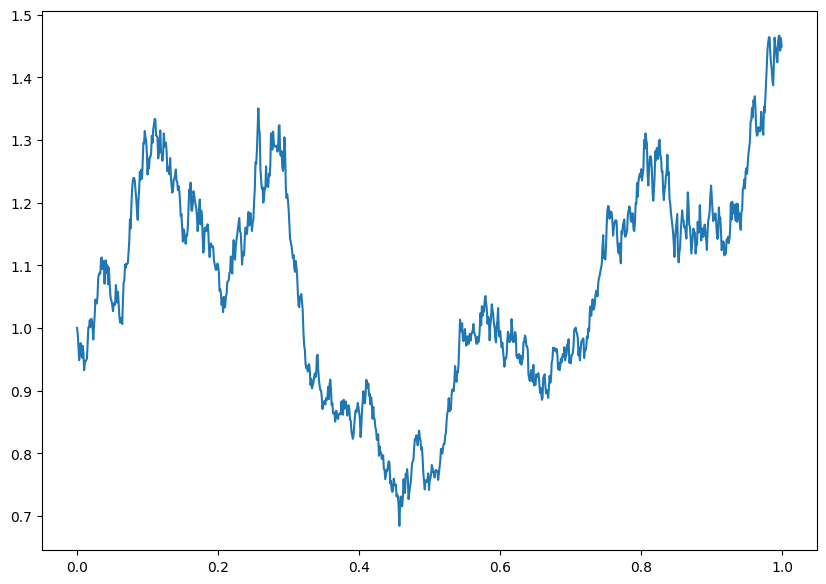

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(*generate_geometric_bm(1, 1, 0.5, 1, 1000))

5. Brownian bridge

In [10]:
def brownian_bridge(start: float, end: float, end_time: float, number_of_points: int):
    ts, ws = generate_wiener(end_time, number_of_points)
    bridge = start + ws - ts / end_time * (ws[-1] - end + start)
    return ts, bridge

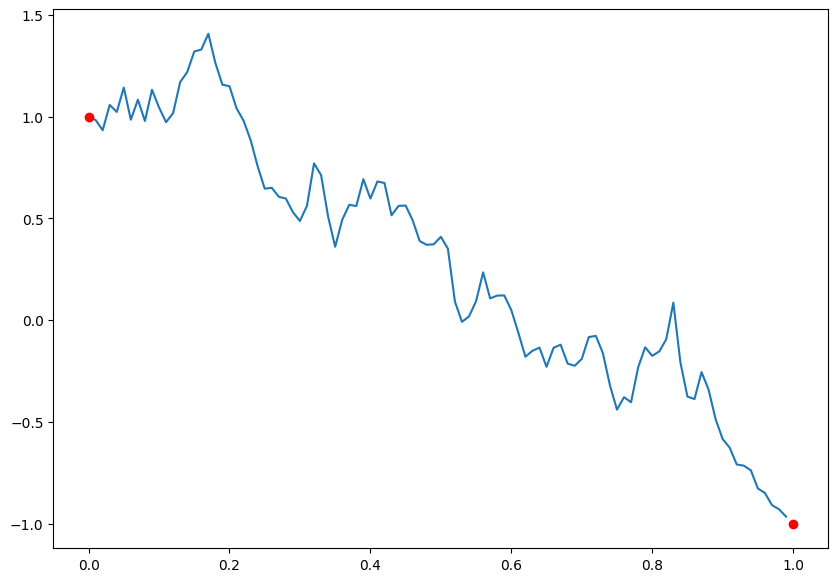

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

x, y = 1, -1

ax.plot(*brownian_bridge(start=x, end=y, end_time=1, number_of_points=100))
ax.plot([0, 1], [x, y], 'or')

### Compensation Problem #1

$$
    X_t = \sigma W_t \\
    Y_t = \nu t + \sigma W_t
$$

In [18]:
def generate_yt(nu: float, sigma: float, number_of_paths: int, number_of_points: int):
    def calculate_weight(w_end: float):
        weight = np.exp(-nu * w_end / sigma - (nu / sigma)**2 / 2)# * sps.norm(loc=nu, scale=1).pdf(w_end)
        weight = sps.norm(scale=sigma**2).pdf(w_end)
        return weight
    
    wieners = np.empty(shape=(number_of_paths, number_of_points))
    for i in range(number_of_paths):
        ts, ws = generate_wiener(1, number_of_points)
        wieners[i] = ws
        
    ys = nu * ts + sigma * wieners
    weights = calculate_weight(wieners[:, -1]) * sps.norm(nu, sigma**2).pdf(ys[:, -1])
    #weights = calculate_weight(ys[:, -1])
    
    return ts, ys, weights

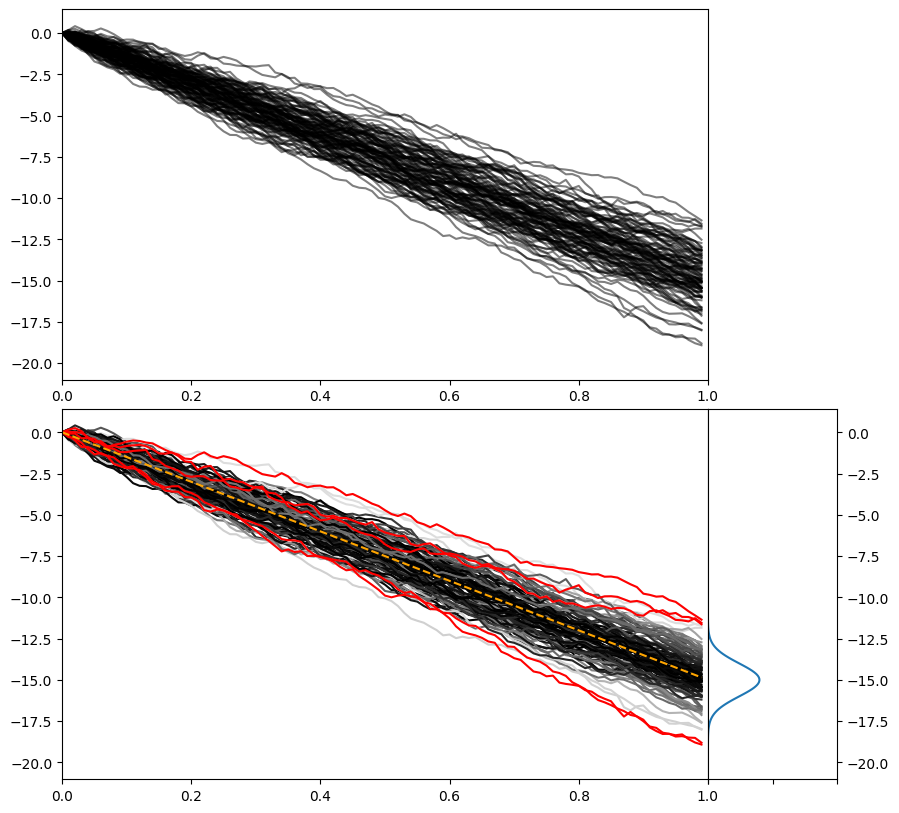

In [23]:
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(8, 6, hspace=0.4, wspace=0)

ax_raw = fig.add_subplot(grid[:4, :-1])
ax_colored = fig.add_subplot(grid[4:, :-1], sharex=ax_raw, sharey=ax_raw)
ax_colored.set_xlim(0, 1)
ax_density = fig.add_subplot(grid[4:, -1], sharey=ax_colored, xticklabels=[])
ax_density.yaxis.tick_right()
ax_density.set_xlim(left=0)

nu = -15
sigma = 1.5
N = 100

ts, ys, weights = generate_yt(nu, sigma, number_of_paths=100, number_of_points=N)

weights = (weights - weights.min()) / (weights.max() - weights.min())

top_min_idxs = np.argsort(weights)[:5]

for y, w in zip(ys, weights):
    ax_raw.plot(ts, y, c='k', alpha=0.5)
    ax_colored.plot(ts, y, c=str(1 - w))
    
for i in top_min_idxs:
    ax_colored.plot(ts, ys[i], c='r')

ws_grid = np.linspace(nu - 5, nu + 5, 100)
ax_colored.plot(ts, nu * ts, '--', color='orange')
ax_density.plot(sps.norm(loc=nu, scale=1 or sigma**2).pdf(ws_grid), ws_grid)